<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_ARIMAX_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMAX

# 1) 한줄 정의 & 차이점

* **$ARIMA(p,d,q)$**: 자기회귀(AR) + 차분(d) + 이동평균(MA)로 **내생 시계열만** 설명
* **$ARIMAX(p,d,q)+X$ **: ARIMA에 **외생 변수(설명변수, exogenous, X)**를 추가
* **$SARIMAX(p,d,q)×(P,D,Q)_s+X$**: ARIMAX에 **계절성(주기 s) ARIMA**까지 결합

  > SARIMAX는 **ARIMAX + 시즌성**의 포괄 모델입니다. (statsmodels는 ARIMAX 도 `SARIMAX` 클래스로 구현)



# 2) 수식(개념)

## (1) ARIMAX


$$\phi(L)(1-L)^d, y_t= c + \theta(L),\varepsilon_t + \beta(L),x_t$$


* $( \phi(L)=1-\phi_1L-\dots-\phi_pL^p)$: AR 다항식
* $( \theta(L)=1+\theta_1L+\dots+\theta_qL^q)$: MA 다항식
* $( (1-L)^d)$: 비계절 차분
* $( x_t )$: 외생 변수(들). **동시·시차(분포지연 (\beta(L)))** 모두 가능
* $( \varepsilon_t)$: 백색잡음

※ 단순 회귀(동시항만): $( \beta(L)x_t = \beta,x_t )$

※ **Transfer Function / Dynamic Regression**: $( \beta(L)x_t = \beta_0x_t + \beta_1x_{t-1} + \cdots )$

## (2) SARIMAX


$\Phi(L^s),\phi(L),(1-L)^d(1-L^s)^D,y_t= c + \Theta(L^s),\theta(L),\varepsilon_t + \beta(L),x_t$


* $( s )$: **계절 주기**(월간 12, 분기 4, 영업일 주간 5 등)
* $( \Phi,\Theta )$: 계절 AR/MA 다항식
* $( D )$: 계절 차분 차수



# 3) 언제 쓰나?

* **ARIMAX**:

  * 주가 **수익률** ~ 시장지수 수익률(SPY), 금리, 환율, 거시지표 등 외생요인이 유의할 때
  * 광고비→매출(시차효과), 금리→환율 같은 **원인→결과** 구조(전이함수)
* **SARIMAX**:

  * 명확한 **계절성**(주/월/분기) + 외생요인 동시 고려
  * 리테일 판매(월별 12), 항공승객(월별 12), 전력수요(주/일 주기) 등



# 4) 실무 체크리스트 (중요)

1. **정상성 확보**

   * 레벨(가격)은 대개 비정상 ⇒ **로그-차분(수익률)** 권장
   * 계절성 있으면 **계절 차분 (D)** 고려

2. **외생 변수(Exog) 준비**

   * **미래 예측에도 필요**: 미래 기간에 대한 exog를 **직접 시나리오**로 넣거나,
     exog도 별도로 예측해서 넣어야 합니다(아니면 예측 불가/상수 가정).
   * **동시성/내생성** 주의: $(x_t)$가 $(y_t)$에 동시에 반응한다면 **엔도지니어티** 문제
     → 시차항 사용, IV/구조적 모형 등 고려

3. **라그 선택 & 모형 선택**

   * ACF/PACF + **AIC/BIC**로 (p,d,q)(P,D,Q) 탐색
   * exog 랙 $((\beta(L)))$ 도 그리드로 같이 비교(너무 크면 과적합)

4. **진단(Diagnostics)**

   * 잔차 **Ljung–Box**: 자기상관 없음?
   * **정규성/등분산성** 확인, 필요 시 **GARCH** 결합 고려
   * **Pseudo out-of-sample**: **rolling-origin** 평가 권장

5. **경고·오류 회피**

   * 인덱스 **주기 지정**: `y = y.asfreq('B')` 등
   * `enforce_stationarity=True`, `enforce_invertibility=True`
   * 최적화 실패 시 `method='lbfgs'`, `maxiter`↑ 또는 다른 솔버 시도



# 5) 해석 포인트

* $(\beta)$가 유의 ⇒ exog가 y에 **추가 설명력**
* 다만, **리스케일링/스케일러** 사용으로 수치 안정성 개선
* 다중공선성$(VIF↑)$ ⇒ 불필요한 exog 줄이기/정규화/정규화 회귀 고려
* **Leakage 금지**: 미래 데이터를 과거에 섞지 않기(정렬·슬라이싱 주의)



# 6) 자주 받는 질문(FAQ)

* **Q. ARIMAX와 “회귀+ARMA오차(Regression with ARMA errors)”는 같나요?**
  넓게 보면 유사합니다. statsmodels의 SARIMAX는 **동시/시차 exog**와 **ARMA 오차**를 함께 다룰 수 있어 **전이함수(transfer function)** 류도 포함합니다.

* **Q. 가격(레벨)로 해도 되나요?**
  가능하지만 대부분 **비정상**입니다. **로그-차분(수익률)**로 바꾸면 안정적으로 추정·진단되죠. 레벨을 쓰려면 적절한 **d,D** 차분 설정이 필요합니다.

* **Q. 경고가 많이 떠요.**

  * 인덱스 주기: `asfreq('B')`
  * 수렴 실패: 다른 `method`, `maxiter↑`
  * 비정상/비가역: `enforce_stationarity=True`, `enforce_invertibility=True`


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TSLA: 1765 returns | 2019-01-03 ~ 2025-10-08
[Fixed]    RMSE=3.3567 | MAE=2.4077 | R2=0.3501
[Rolling]   RMSE=3.3109 | MAE=2.4170 | R2=0.3677
[Expanding] RMSE=3.3309 | MAE=2.3894 | R2=0.3600


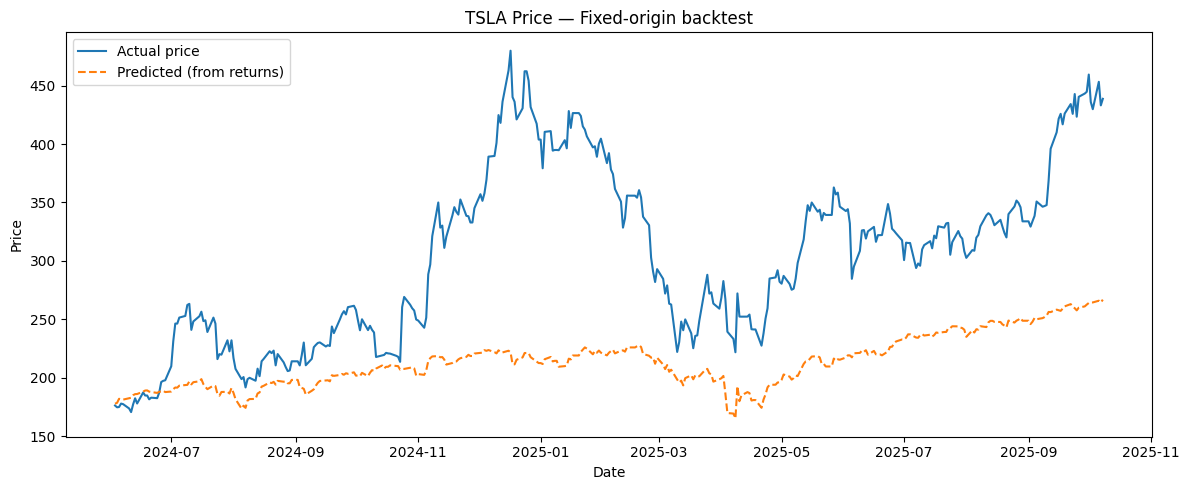

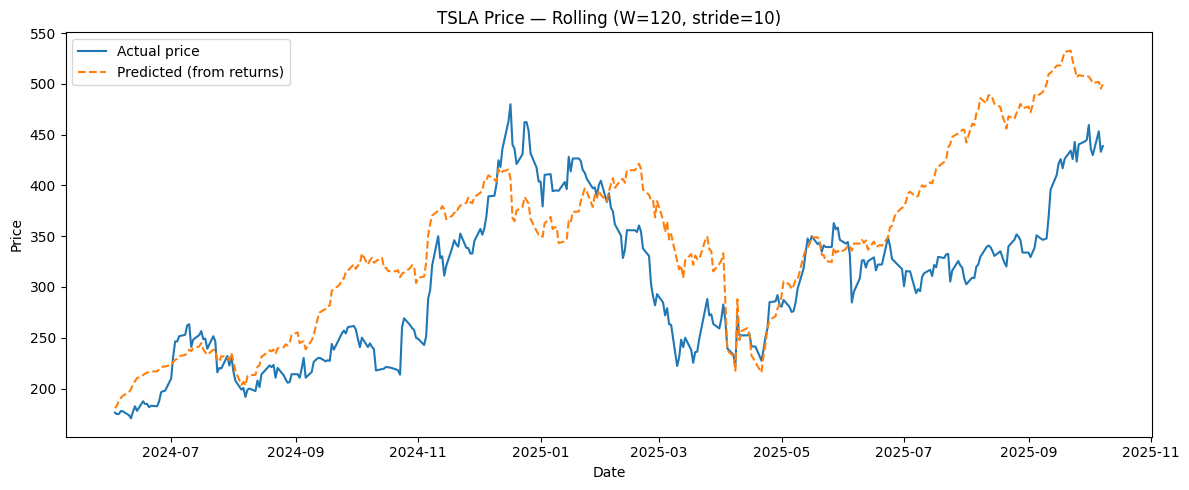

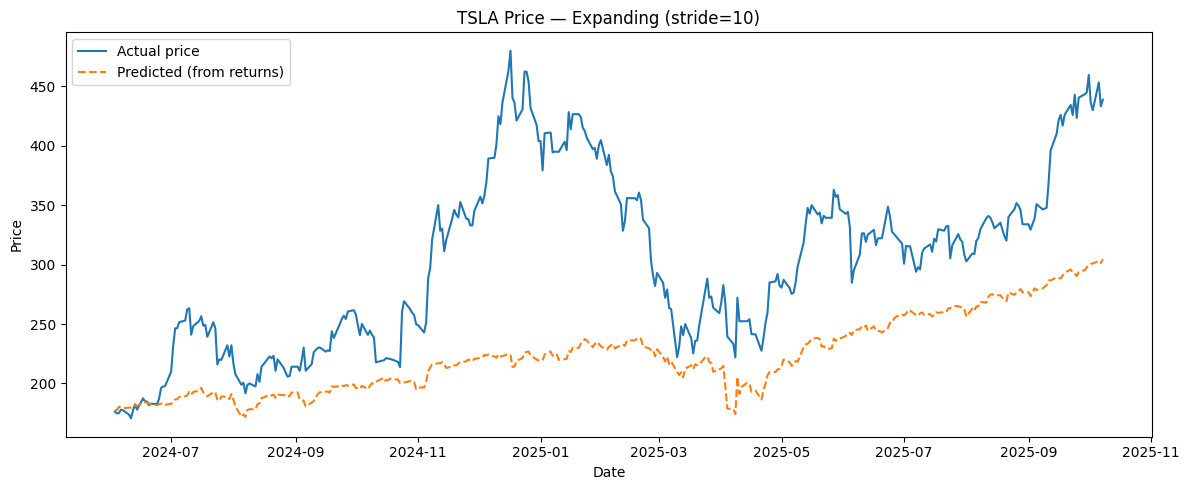

In [3]:
# %pip -q install yfinance statsmodels scikit-learn

import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BusinessDay
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
try:
    from statsmodels.tsa.base.tsa_model import ValueWarning
except Exception:
    class ValueWarning(Warning): pass

# ---- warnings 최소화
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.figsize"] = (12,5)

# =========================================================
# 1) 데이터: TSLA & SPY (조정종가) → 로그수익률(%)
# =========================================================
start, end = "2019-01-01", None
yname, xname = "TSLA", "SPY"

px_y = yf.download(yname, start=start, end=end, auto_adjust=True)[["Close"]].dropna()
px_x = yf.download(xname, start=start, end=end, auto_adjust=True)[["Close"]].dropna()

# 공통 날짜로 내부 조인 후 정렬/빈도 부여(영업일)
px = px_y.join(px_x, how="inner", lsuffix=f"_{yname}", rsuffix=f"_{xname}").sort_index()
px.index = pd.to_datetime(px.index)
px = px.asfreq("B").ffill()  # 레벨을 먼저 ffill → 그 다음 수익률 계산

# 레벨 → 로그수익률(%)
price_y = pd.Series(px.iloc[:,0].astype(float).to_numpy(), index=px.index, name=f"Close_{yname}")
price_x = pd.Series(px.iloc[:,1].astype(float).to_numpy(), index=px.index, name=f"Close_{xname}")

ret_y = np.log(price_y).diff().dropna()*100.0
ret_x = np.log(price_x).diff().dropna()*100.0

df = pd.concat([ret_y, ret_x], axis=1).dropna()
df.columns = ["y", "x"]  # y=TSLA ret, x=SPY ret
df = df.asfreq("B").fillna(0.0)  # 혹시 남은 NaN 간단 보정

y = df["y"].astype(float)
X = df[["x"]].astype(float)

print(f"{yname}: {len(y)} returns | {y.index[0].date()} ~ {y.index[-1].date()}")

# =========================================================
# 2) Train/Test split
# =========================================================
train_size = int(len(y) * 0.8)
y_tr, y_te = y.iloc[:train_size], y.iloc[train_size:]
X_tr, X_te = X.iloc[:train_size], X.iloc[train_size:]
dates_tr, dates_te = y_tr.index, y_te.index

# 테스트 구간 실제 '주가' (비교용)
price_test = price_y.loc[dates_te]

# =========================================================
# 3) 유틸
# =========================================================
rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
mae  = lambda a,b: float(np.mean(np.abs(np.asarray(a)-np.asarray(b))))
r2   = lambda a,b: float(r2_score(a,b))

def fit_sarimax_safe(y, X=None, order=(2,0,2), seasonal_order=(0,0,0,0), trend="n", maxiter=200):
    """안전 적합(수렴 실패 시 다른 솔버 폴백)."""
    for method in ("lbfgs", "powell", "nm"):
        try:
            model = SARIMAX(
                y, exog=X, order=order, seasonal_order=seasonal_order, trend=trend,
                enforce_stationarity=True, enforce_invertibility=True
            )
            res = model.fit(method=method, maxiter=maxiter, disp=False)
            return res
        except Exception:
            continue
    return None

def one_step_pred(model, exog_row):
    """
    [경고 제거 포인트]
    forecast(...)[0] 대신 get_forecast(...).predicted_mean.iloc[0] 사용.
    """
    pm = model.get_forecast(steps=1, exog=exog_row).predicted_mean
    return float(pm.iloc[0])

def returns_to_price_series(pred_ret, dates, anchor_price):
    """
    일별 로그수익률(%) 예측 → 주가 경로로 변환.
    price_t = price_{t-1} * exp(ret_t/100)
    """
    pred_ret = np.asarray(pred_ret, dtype=float)
    out = np.empty_like(pred_ret, dtype=float)
    p = float(anchor_price)
    for i, r in enumerate(pred_ret):
        p *= np.exp(r/100.0)
        out[i] = p
    return pd.Series(out, index=dates, name="pred_price")

# 앵커 주가: 테스트 첫날의 '전일' 주가 (없으면 학습 마지막 날 주가)
anchor_date = dates_te[0] - BusinessDay(1)
if anchor_date in price_y.index:
    anchor_price = float(price_y.loc[anchor_date])
else:
    anchor_price = float(price_y.loc[dates_tr[-1]])

# =========================================================
# 4) 모형 설정 (ARIMAX 예시)
# =========================================================
ORDER  = (2,0,2)
SEASON = (0,0,0,0)

# =========================================================
# 5) A) Fixed-origin — 학습 한 번, 테스트 전구간 예측
# =========================================================
fix_fit = fit_sarimax_safe(y_tr, X_tr, order=ORDER, seasonal_order=SEASON)
pred_fix = (fix_fit.forecast(steps=len(y_te), exog=X_te).to_numpy()
            if fix_fit else np.zeros(len(y_te)))
print(f"[Fixed]    RMSE={rmse(y_te, pred_fix):.4f} | MAE={mae(y_te, pred_fix):.4f} | R2={r2(y_te, pred_fix):.4f}")

# 가격으로 변환
price_pred_fix = returns_to_price_series(pred_fix, dates_te, anchor_price)

# =========================================================
# 6) B) Rolling-origin + Rolling window
#    - 창 W만 사용, stride마다 재적합
# =========================================================
W = 120; stride = 10
pred_roll = np.full(len(y_te), np.nan)
hist_y = y_tr.copy(); hist_X = X_tr.copy()
roll_fit = None

for i, t in enumerate(dates_te):
    y_win = hist_y.iloc[-W:] if len(hist_y) >= W else hist_y
    X_win = hist_X.iloc[-W:] if len(hist_X) >= W else hist_X
    if (i % stride) == 0 or (roll_fit is None):
        roll_fit = fit_sarimax_safe(y_win, X_win, order=ORDER, seasonal_order=SEASON)
    pred_roll[i] = one_step_pred(roll_fit, X_te.loc[[t]]) if roll_fit else 0.0
    # 워크-포워드(실측 주입)
    hist_y = pd.concat([hist_y, y_te.loc[[t]]])
    hist_X = pd.concat([hist_X, X_te.loc[[t]]])

print(f"[Rolling]   RMSE={rmse(y_te, pred_roll):.4f} | MAE={mae(y_te, pred_roll):.4f} | R2={r2(y_te, pred_roll):.4f}")

price_pred_roll = returns_to_price_series(pred_roll, dates_te, anchor_price)

# =========================================================
# 7) C) Rolling-origin + Expanding window
# =========================================================
pred_exp = np.full(len(y_te), np.nan)
hist_y = y_tr.copy(); hist_X = X_tr.copy()
exp_fit = None

for i, t in enumerate(dates_te):
    if (i % stride) == 0 or (exp_fit is None):
        exp_fit = fit_sarimax_safe(hist_y, hist_X, order=ORDER, seasonal_order=SEASON)
    pred_exp[i] = one_step_pred(exp_fit, X_te.loc[[t]]) if exp_fit else 0.0
    # 워크-포워드
    hist_y = pd.concat([hist_y, y_te.loc[[t]]])
    hist_X = pd.concat([hist_X, X_te.loc[[t]]])

print(f"[Expanding] RMSE={rmse(y_te, pred_exp):.4f} | MAE={mae(y_te, pred_exp):.4f} | R2={r2(y_te, pred_exp):.4f}")

price_pred_exp = returns_to_price_series(pred_exp, dates_te, anchor_price)

# =========================================================
# 8) 주가 그래프 (각 백테스트별로 개별 그림)
# =========================================================
def plot_price(actual, pred, title):
    plt.figure()
    plt.plot(actual.index, actual.values, label="Actual price")
    plt.plot(pred.index, pred.values, linestyle="--", label="Predicted (from returns)")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
    plt.tight_layout(); plt.show()

plot_price(price_test, price_pred_fix,  f"{yname} Price — Fixed-origin backtest")
plot_price(price_test, price_pred_roll, f"{yname} Price — Rolling (W=120, stride=10)")
plot_price(price_test, price_pred_exp,  f"{yname} Price — Expanding (stride=10)")


# SARIMAX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TSLA: 1765 returns | 2019-01-03 ~ 2025-10-08
[Fixed]    RMSE=3.3550 | MAE=2.4066 | R2=0.3507
[Rolling]   RMSE=3.4105 | MAE=2.4608 | R2=0.3291
[Expanding] RMSE=3.3142 | MAE=2.3770 | R2=0.3665


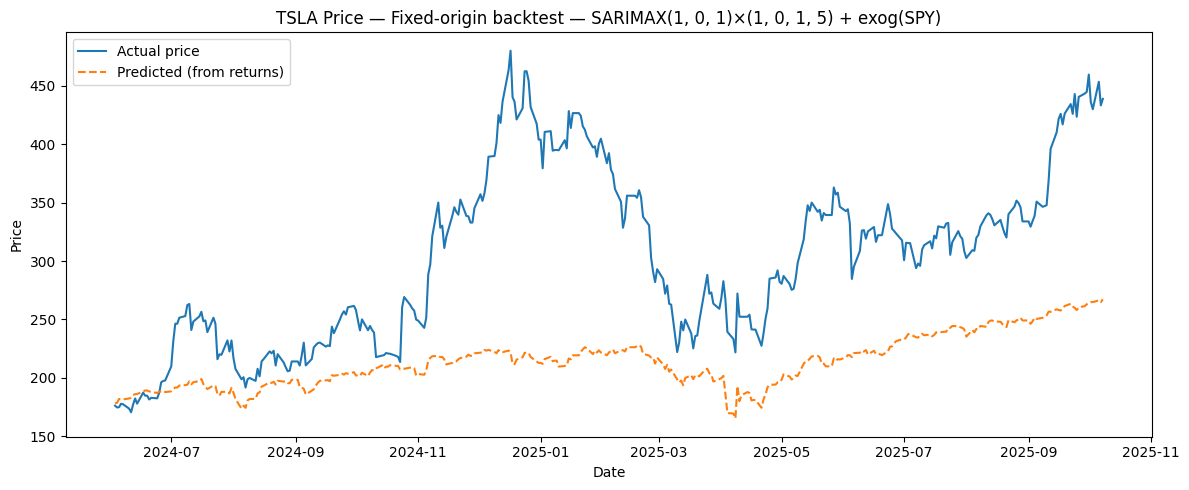

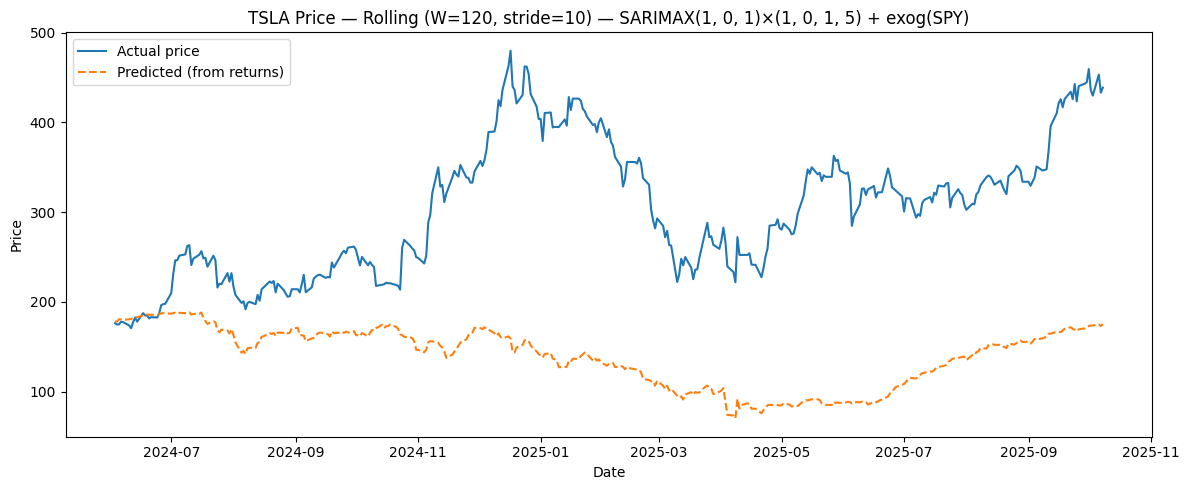

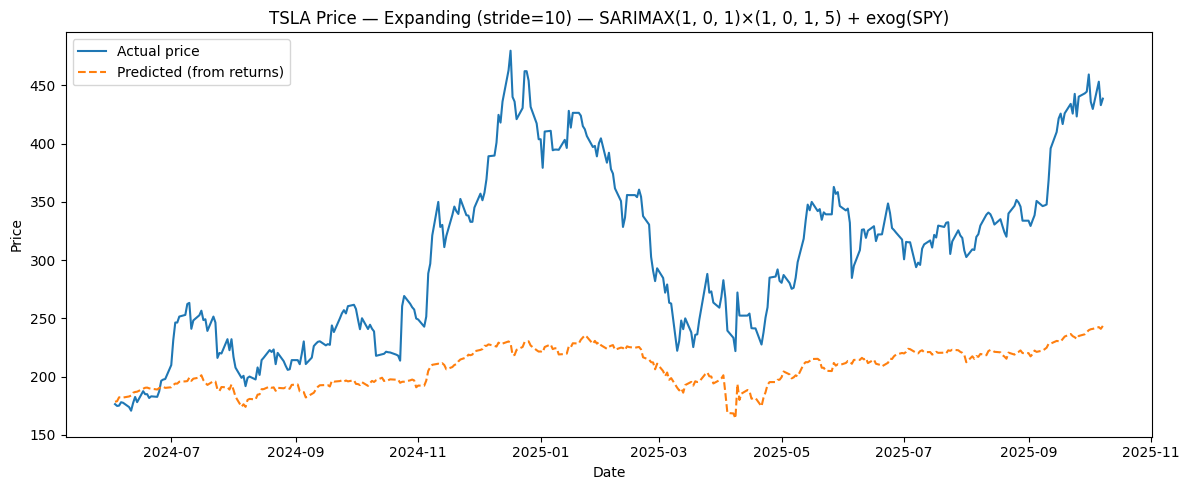

In [4]:
# %pip -q install yfinance statsmodels scikit-learn

import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BusinessDay
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
try:
    from statsmodels.tsa.base.tsa_model import ValueWarning
except Exception:
    class ValueWarning(Warning): pass

# ---- warnings 최소화
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.figsize"] = (12,5)

# =========================================================
# 1) 데이터: TSLA(종속) & SPY(외생) → 로그수익률(%)
# =========================================================
start, end = "2019-01-01", None
yname, xname = "TSLA", "SPY"

px_y = yf.download(yname, start=start, end=end, auto_adjust=True)[["Close"]].dropna()
px_x = yf.download(xname, start=start, end=end, auto_adjust=True)[["Close"]].dropna()

# 공통 날짜로 내부 조인 → 정렬 → 영업일 빈도 부여 → 결측 보간
px = px_y.join(px_x, how="inner", lsuffix=f"_{yname}", rsuffix=f"_{xname}").sort_index()
px.index = pd.to_datetime(px.index)
px = px.asfreq("B").ffill()

# 레벨 시계열
price_y = pd.Series(px.iloc[:,0].astype(float).to_numpy(), index=px.index, name=f"Close_{yname}")
price_x = pd.Series(px.iloc[:,1].astype(float).to_numpy(), index=px.index, name=f"Close_{xname}")

# 로그수익률(%) 계산
ret_y = np.log(price_y).diff().dropna() * 100.0
ret_x = np.log(price_x).diff().dropna() * 100.0

df = pd.concat([ret_y, ret_x], axis=1).dropna()
df.columns = ["y", "x"]         # y=TSLA 수익률, x=SPY 수익률(외생)
df = df.asfreq("B").fillna(0.0) # 혹시 남은 NaN 간단 보정

y = df["y"].astype(float)
X = df[["x"]].astype(float)

print(f"{yname}: {len(y)} returns | {y.index[0].date()} ~ {y.index[-1].date()}")

# =========================================================
# 2) Train/Test split
# =========================================================
train_size = int(len(y) * 0.8)
y_tr, y_te = y.iloc[:train_size], y.iloc[train_size:]
X_tr, X_te = X.iloc[:train_size], X.iloc[train_size:]
dates_tr, dates_te = y_tr.index, y_te.index
price_test = price_y.loc[dates_te]  # 실제 주가(비교용)

# =========================================================
# 3) 유틸
# =========================================================
rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
mae  = lambda a,b: float(np.mean(np.abs(np.asarray(a)-np.asarray(b))))
r2   = lambda a,b: float(r2_score(a,b))

def fit_sarimax_safe(y, X=None, order=(1,0,1), seasonal_order=(1,0,1,5), trend="n", maxiter=300):
    """안전 적합(수렴 실패 시 다른 솔버 폴백). SARIMAX + exog 지원."""
    for method in ("lbfgs", "powell", "nm"):
        try:
            model = SARIMAX(
                y, exog=X, order=order, seasonal_order=seasonal_order, trend=trend,
                enforce_stationarity=True, enforce_invertibility=True
            )
            res = model.fit(method=method, maxiter=maxiter, disp=False)
            return res
        except Exception:
            continue
    return None

def one_step_pred(model, exog_row):
    """경고 없이 1스텝 예측값 추출."""
    pm = model.get_forecast(steps=1, exog=exog_row).predicted_mean
    return float(pm.iloc[0])

def returns_to_price_series(pred_ret, dates, anchor_price):
    """수익률(%) 경로 → 주가 경로로 변환."""
    pred_ret = np.asarray(pred_ret, dtype=float)
    out = np.empty_like(pred_ret, dtype=float)
    p = float(anchor_price)
    for i, r in enumerate(pred_ret):
        p *= np.exp(r/100.0)
        out[i] = p
    return pd.Series(out, index=dates, name="pred_price")

# 앵커 주가(테스트 첫날 직전 영업일, 없으면 학습 마지막 날)
anchor_date = dates_te[0] - BusinessDay(1)
anchor_price = float(price_y.loc[anchor_date] if anchor_date in price_y.index else price_y.loc[dates_tr[-1]])

# =========================================================
# 4) SARIMAX 모형 설정
#    - returns는 보통 비계절성이나, 데모용으로 주간 시즌성(s=5 영업일) 추가
# =========================================================
ORDER  = (1,0,1)     # (p,d,q)
SEASON = (1,0,1,5)   # (P,D,Q,s)  ← s=5: 주간(영업일 기준)

# =========================================================
# 5) A) Fixed-origin — 학습 한 번, 테스트 전구간 예측
# =========================================================
fix_fit = fit_sarimax_safe(y_tr, X_tr, order=ORDER, seasonal_order=SEASON)
pred_fix = (fix_fit.forecast(steps=len(y_te), exog=X_te).to_numpy()
            if fix_fit else np.zeros(len(y_te)))
print(f"[Fixed]    RMSE={rmse(y_te, pred_fix):.4f} | MAE={mae(y_te, pred_fix):.4f} | R2={r2(y_te, pred_fix):.4f}")
price_pred_fix = returns_to_price_series(pred_fix, dates_te, anchor_price)

# =========================================================
# 6) B) Rolling-origin + Rolling window (W만 사용, stride마다 재적합)
# =========================================================
W = 120; stride = 10
pred_roll = np.full(len(y_te), np.nan)
hist_y = y_tr.copy(); hist_X = X_tr.copy()
roll_fit = None

for i, t in enumerate(dates_te):
    y_win = hist_y.iloc[-W:] if len(hist_y) >= W else hist_y
    X_win = hist_X.iloc[-W:] if len(hist_X) >= W else hist_X
    if (i % stride) == 0 or (roll_fit is None):
        roll_fit = fit_sarimax_safe(y_win, X_win, order=ORDER, seasonal_order=SEASON)
    pred_roll[i] = one_step_pred(roll_fit, X_te.loc[[t]]) if roll_fit else 0.0
    hist_y = pd.concat([hist_y, y_te.loc[[t]]])  # 워크-포워드
    hist_X = pd.concat([hist_X, X_te.loc[[t]]])

print(f"[Rolling]   RMSE={rmse(y_te, pred_roll):.4f} | MAE={mae(y_te, pred_roll):.4f} | R2={r2(y_te, pred_roll):.4f}")
price_pred_roll = returns_to_price_series(pred_roll, dates_te, anchor_price)

# =========================================================
# 7) C) Rolling-origin + Expanding window
# =========================================================
pred_exp = np.full(len(y_te), np.nan)
hist_y = y_tr.copy(); hist_X = X_tr.copy()
exp_fit = None

for i, t in enumerate(dates_te):
    if (i % stride) == 0 or (exp_fit is None):
        exp_fit = fit_sarimax_safe(hist_y, hist_X, order=ORDER, seasonal_order=SEASON)
    pred_exp[i] = one_step_pred(exp_fit, X_te.loc[[t]]) if exp_fit else 0.0
    hist_y = pd.concat([hist_y, y_te.loc[[t]]])
    hist_X = pd.concat([hist_X, X_te.loc[[t]]])

print(f"[Expanding] RMSE={rmse(y_te, pred_exp):.4f} | MAE={mae(y_te, pred_exp):.4f} | R2={r2(y_te, pred_exp):.4f}")
price_pred_exp = returns_to_price_series(pred_exp, dates_te, anchor_price)

# =========================================================
# 8) 주가 그래프 (각 백테스트별로 별도 플롯)
# =========================================================
def plot_price(actual, pred, title):
    plt.figure()
    plt.plot(actual.index, actual.values, label="Actual price")
    plt.plot(pred.index, pred.values, linestyle="--", label="Predicted (from returns)")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
    plt.tight_layout(); plt.show()

title_tag = f"SARIMAX{ORDER}×{SEASON} + exog({xname})"
plot_price(price_test, price_pred_fix,  f"{yname} Price — Fixed-origin backtest — {title_tag}")
plot_price(price_test, price_pred_roll, f"{yname} Price — Rolling (W=120, stride=10) — {title_tag}")
plot_price(price_test, price_pred_exp,  f"{yname} Price — Expanding (stride=10) — {title_tag}")
